# Importación de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense

# Carga de datos

In [2]:
headers = pd.read_csv('../Data/handles-data.csv')
tweets = pd.read_csv('../Data/tweets-data.csv')
pd.options.display.float_format = '{:.2f}'.format

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Target Clasificación

In [3]:
tweets["nretweets"].isnull().sum()

0

In [4]:
tweets["nretweets"].quantile([0.7,0.8,0.9,0.95,1])

0.70       49.00
0.80      104.00
0.90      311.00
0.95      871.00
1.00   541964.00
Name: nretweets, dtype: float64

## Pipeline Target

In [5]:
def pipeline_qcut_label(dataset):
    # very_unpopular:0 unpopular:1 popular:2 very_popular:1
    dataset["categorias"] = pd.qcut(dataset["nretweets"], [0.7,0.8,0.9,0.95,1], labels=["0","1","2","3"])
    dataset["categorias"][dataset["categorias"].isnull()] = "0"
    # df = pd.get_dummies(tweets, columns=["categorias"])
    return dataset[["categoria"]]

In [6]:
# tweets_label_categorical = pipeline_qcut_label(tweets)

In [7]:
# tweets_label_categorical

Establezco todos los tweets como poco populares de entrada, así si exiten nulos estos estarán como "poco populares". De esta forma, aquellos tweets que están por debajo o igual al percentil 80 serán como poco populares.

In [8]:
# very_unpopular:0 unpopular:1 popular:2 very_popular:1
tweets["label"] = pd.qcut(tweets["nretweets"], [0.7,0.8,0.90,0.95,1], labels=["0", "1","2", "3"])

In [9]:
tweets["label"][tweets["label"].isnull()] = "0"

In [10]:
tweets["label"].head(8)

0    1
1    2
2    2
3    2
4    3
5    2
6    3
7    0
Name: label, dtype: category
Categories (4, object): ['0' < '1' < '2' < '3']

In [11]:
tweets.groupby('label').size()

label
0    32523
1     4006
2     2023
3     2029
dtype: int64

In [12]:
tweets[tweets["nretweets"]>871]["nretweets"].count()

2029

In [13]:
tweets[tweets["label"]=="3"]["label"].count()

2029

In [14]:
tweets[tweets["nretweets"]<=104]["nretweets"].count()

32523

In [15]:
tweets[tweets["label"]=="0"]["label"].count()

32523

In [16]:
tweets[tweets["label"].isnull()]["label"].count()

0

In [17]:
# tweets_categorical = pd.get_dummies(tweets, columns=["label"])

In [18]:
# tweets_categorical.head()

In [19]:
print(tweets[tweets["label"].isnull()]["label"].count())

0


<AxesSubplot:xlabel='label', ylabel='Count'>

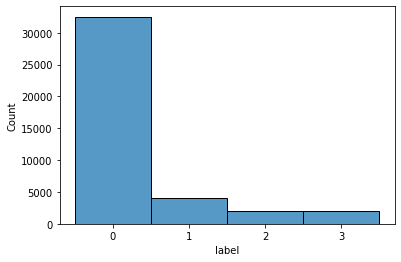

In [20]:
sns.histplot(data=tweets,x=tweets["label"])

# Variables Relevantes

### Unir los datos

In [21]:
union = pd.merge(headers, tweets, left_on='username', right_on='username' )
union.describe()
union.to_csv("../Data/union.csv",sep=";", index=False)

In [22]:
union = pd.read_csv("../Data/union.csv", sep=";")

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Followers

Considerando el análisis inicial de los datos, el número de seguidores (followers), sigue siendo una variable a tener en cuenta para conocer la popularidad de un tweet.
En este caso, en vez de tomarlo como numérico, lo pasaremos a categórico.

En primer lugar observamos la dispersión de los datos:

In [23]:
headers["followers"].quantile([0.4,0.5,0.65,0.7,0.8,0.85,0.9,0.95,1])

0.40     3705270.00
0.50     4462139.00
0.65     6345799.50
0.70     7216548.00
0.80    10608102.00
0.85    13958885.50
0.90    18754004.00
0.95    36826698.00
1.00   129909278.00
Name: followers, dtype: float64

Considerando que el primer salto importante se da entre el percentil 60 y 80, empezaremos a dividir los datos por categorías, en este caso en dos. Siendo por ejemplo, número de seguidores "no relevante" y "relevante".
Tomo esta decisión ya que en el dataset todos tienen una cantidad de followers exagerada, y creo que es mejor dividirlo de esta forma.

In [24]:
union["followers_categorical"] = pd.qcut(union["followers"], [0.60,0.80,1], labels=["0", "1"])

In [25]:
union["followers_categorical"]

0          1
1          1
2          1
3          1
4          1
        ... 
40862    NaN
40863    NaN
40864    NaN
40865    NaN
40866    NaN
Name: followers_categorical, Length: 40867, dtype: category
Categories (2, object): ['0' < '1']

In [26]:
union["followers_categorical"][union["followers_categorical"].isnull()] = "0"

In [27]:
union[union["followers_categorical"].isnull()]["followers_categorical"].count()

0

<AxesSubplot:xlabel='followers_categorical', ylabel='Count'>

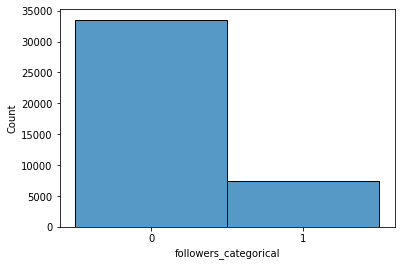

In [28]:
sns.histplot(data=union,x=union["followers_categorical"])

## Tiene URLS

In [29]:
union["have_urls"] = union["urls"] != "[]"

In [30]:
union.loc[union["have_urls"] == True, 'have_urls'] = "1"

In [31]:
union.loc[union["have_urls"] == False, 'have_urls'] = "0"

In [32]:
union["have_urls"]

0        0
1        0
2        0
3        1
4        0
        ..
40862    0
40863    0
40864    0
40865    0
40866    0
Name: have_urls, Length: 40867, dtype: object

In [33]:
union["have_urls"].value_counts(sort=True)

1    22015
0    18852
Name: have_urls, dtype: int64

<AxesSubplot:xlabel='have_urls', ylabel='Count'>

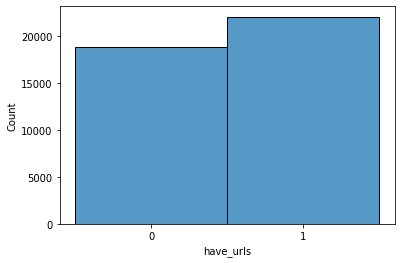

In [34]:
sns.histplot(data=union,x=union["have_urls"])

## Tiene Hashtags

In [35]:
union["hashtags"].head(15)

0                                         []
1     ['shoesdaytuesday', 'afterskewlslide']
2                                         []
3                                         []
4                                         []
5                       ['climateemergency']
6                                         []
7                                         []
8                                         []
9                                         []
10                                        []
11                                        []
12                                        []
13                                        []
14                               ['freeguy']
Name: hashtags, dtype: object

In [36]:
union["have_hashtags"] = union["hashtags"] != "[]"

In [37]:
union.loc[union["have_hashtags"] == True, 'have_hashtags'] = "1"
union.loc[union["have_hashtags"] == False, 'have_hashtags'] = "0"

In [38]:
union["have_hashtags"].value_counts(sort=True)

0    35528
1     5339
Name: have_hashtags, dtype: int64

<AxesSubplot:xlabel='have_hashtags', ylabel='Count'>

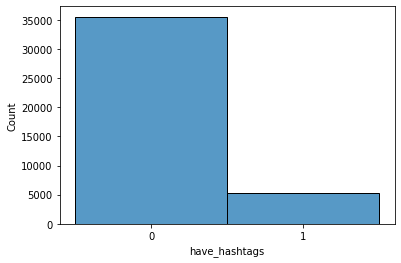

In [39]:
sns.histplot(data=union,x=union["have_hashtags"])

## Fecha de unión

In [40]:
union["join_date"] = pd.to_datetime(union["join_date"])
union["join_date"] = union["join_date"].dt.year

In [41]:
union["join_date"]

0        2011
1        2009
2        2009
3        2009
4        2009
         ... 
40862    2011
40863    2011
40864    2011
40865    2011
40866    2011
Name: join_date, Length: 40867, dtype: int64

# Variables Modelo

In [42]:
variables = union[["followers_categorical", "have_urls", "have_hashtags", "join_date"]]

In [43]:
variables.head(10)

,followers_categorical,have_urls,have_hashtags,join_date
0,1,0,0,2011
1,1,0,1,2009
2,1,0,0,2009
3,1,1,0,2009
4,1,0,0,2009
5,1,0,1,2009
6,1,0,0,2008
7,1,0,0,2009
8,1,0,0,2009
9,1,0,0,2009


In [44]:
variables.groupby(["join_date","followers_categorical","have_urls"]).count()

have_hashtags
join_date followers_categorical have_urls               
2006      0                     0                     74
                                1                      7
          1                     0                      0
                                1                      0
2007      0                     0                   1763
                                1                   6248
          1                     0                    683
                                1                   4434
2008      0                     0                   2795
                                1                   5362
          1                     0                    288
                                1                    390
2009      0                     0                   4708
                                1                   3599
          1                     0                    902
                                1                    170
2010      0                     0                   2601
                                1                    381
          1                     0                    137
                                1                     14
2011      0                     0                   2731
                                1                   1037
          1                     0                     94
                                1                     21
2012      0                     0                    933
                                1                     97
          1                     0                    186
                                1                     25
2013      0                     0                    378
                                1                     66
          1                     0                      4
                                1                      0
2014      0                     0                    302
                                1                    110
          1                     0                      0
                                1                      0
2015      0                     0                     79
                                1                      3
          1                     0                      0
                                1                      0
2016      0                     0                     14
                                1                     17
          1                     0                      0
                                1                      0
2017      0                     0                     69
                                1                      7
          1                     0                      0
                                1                      0
2018      0                     0                      9
                                1                      0
          1                     0                      0
                                1                      0
2020      0                     0                     68
                                1                     20
          1                     0                      0
                                1                      0
2021      0                     0                     34
                                1                      7
          1                     0                      0
                                1                      0

In [71]:
target = union[["label"]].copy(deep=True)

In [66]:
target.shape

(40867,)

In [48]:
variables.shape

(40867, 4)

In [77]:
target.head(8)

,label
0,1
1,2
2,2
3,2
4,3
5,2
6,3
7,0


# Separación de datos train/test

In [73]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.3, random_state=25 )

In [98]:
y_train.head(8)

,label
39447,0
1286,0
5726,0
4633,0
22650,0
12019,0
22132,0
973,2


In [81]:
X_train.astype(float)

,followers_categorical,have_urls,have_hashtags,join_date
39447,0.00,1.00,1.00,2007.00
1286,0.00,1.00,0.00,2008.00
5726,0.00,0.00,1.00,2009.00
4633,1.00,0.00,0.00,2009.00
22650,1.00,1.00,0.00,2007.00
...,...,...,...,...
35702,1.00,1.00,0.00,2007.00
26767,0.00,1.00,0.00,2008.00
6618,0.00,0.00,1.00,2010.00
24894,0.00,1.00,0.00,2007.00


# Entrenamiento

In [51]:
from keras.models import Sequential
from keras.layers import Dense

In [95]:
model = Sequential()
model.add(Dense(20, activation="relu", input_dim=4))
model.add(Dense(28, activation="relu"))
model.add(Dense(1, activation="softmax"))

In [96]:
model.compile(loss='categorical_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                100       
                                                                 
 dense_7 (Dense)             (None, 28)                588       
                                                                 
 dense_8 (Dense)             (None, 1)                 29        
                                                                 
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(X_train.astype(float),y_train, epochs=5 )

Epoch 1/5
894/894 [==============================] - 3s 3ms/step - loss: 0.0000e+00
Epoch 2/5
894/894 [==============================] - 3s 3ms/step - loss: 0.0000e+00
Epoch 3/5
894/894 [==============================] - 3s 3ms/step - loss: 0.0000e+00
Epoch 4/5
894/894 [==============================] - 3s 3ms/step - loss: 0.0000e+00
Epoch 5/5
894/894 [==============================] - 2s 3ms/step - loss: 0.0000e+00


In [94]:
history.history

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0]}